In [1]:
# pip3 instacll opencv-python sklearn matplotlib scikit-learn scipy
# NOTE: if any error after installing with pip, use brew for Mac or conda for Windows
import json
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow
from keras import layers
from keras.applications import ResNet50, MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
from keras import backend as K
import gc
import tensorflow as tf
from functools import partial
from sklearn import metrics
from collections import Counter
import itertools
%matplotlib inline

# Loading & Preprocessing

In [2]:
benign_train = np.load('/Users/macbook/cancern-treatment/benign_test.npy')
benign_test = np.load('/Users/macbook/cancern-treatment/benign_test.npy')
malign_train = np.load('/Users/macbook/cancern-treatment/malign_train.npy')
malign_test = np.load('/Users/macbook/cancern-treatment/malign_test.npy')

# Create Label

In [3]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test)) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [17]:
%store X_train X_test Y_train Y_test

Stored 'X_train' (ndarray)
Stored 'X_test' (ndarray)
Stored 'Y_train' (ndarray)
Stored 'Y_test' (ndarray)


# Train and Evalutation split

In [4]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

In [15]:
%store x_train x_val y_train y_val 

Stored 'x_train' (ndarray)
Stored 'x_val' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_val' (ndarray)


# Data Generator

In [5]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
        zoom_range=2, 
        rotation_range = 90,
        horizontal_flip=True, 
        vertical_flip=True, 
    )

# Model: ResNet50

In [6]:
def build_model(backbone, lr=5e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [7]:
from keras import backend as K
import gc
from keras.applications import ResNet50

K.clear_session()
gc.collect()

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

2023-02-13 10:25:00.500212: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-13 10:25:00.500567: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                         

/Users/macbook/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="best_weights"
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [9]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=1,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

2023-02-13 10:25:04.685701: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-13 10:25:07.284221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


101/100 [==============================] - ETA: 0s - loss: 0.4918 - accuracy: 0.7871

2023-02-13 10:26:42.101560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.64845, saving model to best_weights
100/100 [==============================] - 106s 999ms/step - loss: 0.4918 - accuracy: 0.7871 - val_loss: 2.4196 - val_accuracy: 0.6484 - lr: 1.0000e-04


# Save Trained Model
(to re-use later in another .ipynb)

In [10]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
np.save('history.npy',history.history)
# TO DO: rmeove or rename above

In [11]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<AxesSubplot: >

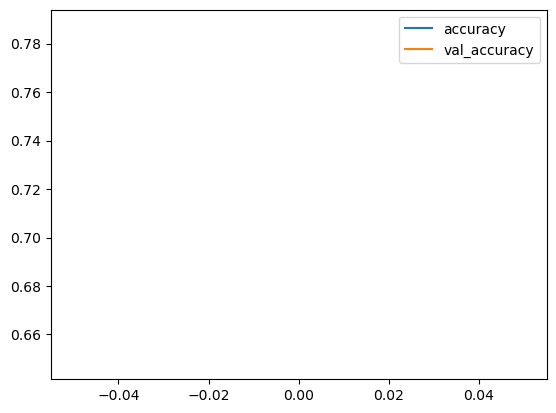

In [12]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot: >

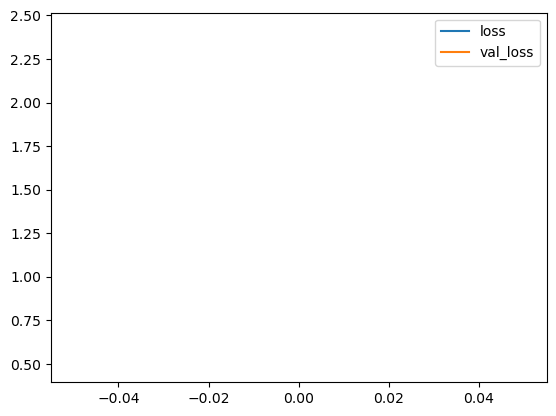

In [13]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()